Versions:
* 20231115 - updated to make consistent with NICERDAS 11a/HEASoft 6.32.1 (requires python version > 3.8)

In [1]:
import os
os.environ['HEASOFTPYDIR']= os.path.split(os.getcwd())[0]

import sys
sys.path.insert(0,os.environ['HEASOFTPYDIR'])
sys.path


from matplotlib.pyplot import *
import glob

import heasoftpy as hsp
import xspec

from astropy.table import Table
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

import warnings 
import astropy.utils as au
warnings.filterwarnings('ignore', category=au.exceptions.AstropyWarning, append=True)


print('Done with imports')

Done with imports


# Setup

First set up the NICER obsid directory

We'll **assume** the user has downloaded the NICER observation directory for OBSID ``4142010107`` in a directory called ``~/tmp/nicer``

The directory ``~/tmp/nicer/4142010107`` contains the ``xti``, ``auxil`` and ``hk`` directories containing the standard archived data for the observation


In [2]:
cwd = os.getcwd()
home = os.environ['HOME']
nicerdatadir = os.path.join(home, 'tmp/nicer')
print(f'Changing directory to {nicerdatadir}')
os.chdir(nicerdatadir)

Changing directory to /Users/mcorcora/tmp/nicer


# Prepare NICER Data

In this example we'll use the NICER ObsID 4142010107, an observation of Cyg X-3, and assume the ObsID directory from the <a href="https://heasarc.gsfc.nasa.gov/FTP/nicer/data/obs/2021_11/4142010107">HEASARC NICER archive</a> has been copied to the ``nicerdatadir`` directory defined above.

### Define output directory (``outdir``)

In [3]:
nicerobsID = '4142010107'
obsdir = os.path.join(nicerdatadir, nicerobsID)

# place cleaned output in a separate directory
outdir =  os.path.join(os.environ['HOME'],'tmp/nicer/','nicerl2_output/'+nicerobsID+'_out')


In [4]:
# if outdir doesn't exist, create it
if not os.path.exists(outdir):
    os.makedirs(outdir)
    print(f'Created {outdir}')
mkf = os.path.join(obsdir,'auxil',f'ni{nicerobsID}.mkf')
if os.path.exists(mkf):
    # see if mkf is gzipped    
    cmd = f'cp {mkf} {outdir}/.'
    stat=os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
elif os.path.exists(mkf+'.gz'):
    #try to copy gzipped mkf     
    cmd = f'cp {mkf}.gz {outdir}/.'
    print(cmd)
    os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
cmd = f'chmod u+w {mkf}*'
print(cmd)
stat = os.system(cmd)

Created /Users/mcorcora/tmp/nicer/nicerl2_output/4142010107_out
Setting mkf file to /Users/mcorcora/tmp/nicer/nicerl2_output/4142010107_out/ni4142010107.mkf
chmod u+w /Users/mcorcora/tmp/nicer/nicerl2_output/4142010107_out/ni4142010107.mkf*


# Geomagnetic data 

First, download the geomagnetic data (used to estimate background) using  ``nigeodown`` (see https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/geomag/)

In [5]:
# set the GEOMAG_PATH environment variable

os.environ['GEOMAG_PATH'] = os.path.join(nicerdatadir, 'geomag')

nigeodown = hsp.HSPTask('nigeodown')
res = nigeodown(clobber='yes')
if res.returncode == 0:
    print(f'Successfully downloaded geomagnetic quantities to {os.environ["GEOMAG_PATH"]}')
else:
    print(f'Could not download geomag quantities to {os.environ["GEOMAG_PATH"]}')
    print(res.stdout)

Successfully downloaded geomagnetic quantities to /Users/mcorcora/tmp/nicer/geomag


# Dating Processing

Use ``nicerl2`` to process your NICER observation.  We'll put the output from nicerl2 in an output directory (``outdir``, defined above) separate from the input directory

In [6]:
tstart = Time.now()
print(f'Start nicerl2 at: {tstart.iso[:19]}')
nicerl2 = hsp.HSPTask('nicerl2')

nicerl2.clobber="yes"
# add the KP values to the mkf file during nicerl2 processing
nicerl2.geomag_path=os.environ['GEOMAG_PATH']
nicerl2.geomag_columns = 'FILTCOLUMNS'
nicerl2.filtcolumns = 'NICERV5'

resl2 = nicerl2(indir=nicerobsID, noprompt=True, cldir=outdir, mkfile=mkf)

tend = Time.now()
print(f'End at: {tend.iso[:19]}')
print(f'nicerl2 took: {(tend.mjd-tstart.mjd)*86400:.1f} seconds')

if resl2.returncode == 0:
    print('nicerl2 completed successfully')
else:
    print('PROBLEM running nicerl2', end='\n\n')
    print(resl2.output)


Start nicerl2 at: 2023-12-05 20:14:16
End at: 2023-12-05 20:15:59
nicerl2 took: 103.5 seconds
nicerl2 completed successfully


# Extract Products

The Recommended way to extract products from cleaned events file: use ``nicerl3-spect`` and ``nicerl3-lc``

### Running ``nicerl3-spect``
Use the ``scorpeon`` background model to create an estimated NICER background spectrum for the observation.  For simplicity we'll use the ``scorpeon`` model to create a background file that can be subtracted from the gross source spectrum

In [7]:
nicerl3spect = hsp.HSPTask('nicerl3-spect')

nicerl3spect.cldir = outdir
nicerl3spect.mkfile = mkf
nicerl3spect.indir = outdir
nicerl3spect.clobber = True
nicerl3spect.bkgmodeltype  = 'scorpeon'
nicerl3spect.format = 'file'
nicerl3spect.bkgformat = 'file'

print(f'Start nicerl3-spect at: {tstart.iso[:19]}')


resl3s = nicerl3spect()
if resl3s.returncode == 0:
    print('nicerl3-spect completed successfully')
else:
    print('PROBLEM running nicerl3-spect', end='\n\n')
    print(f'Return code = {resl3s.returncode}')
    print(resl3s.stdout)


Start nicerl3-spect at: 2023-12-05 20:14:16
nicerl3-spect completed successfully


### Running ``nicerl3-lc``

This creates a gross source lightcurve (no background subtraction) with a ``timebin = 10`` seconds in the PI channel range 30-800 (roughly 0.3 - 8 keV).

In [8]:
nicerl3lc = hsp.HSPTask('nicerl3-lc')

nicerl3lc.indir = outdir
nicerl3lc.cldir = outdir
nicerl3lc.mkfile = mkf
nicerl3lc.clobber = True
nicerl3lc.bkgmodeltype  = 'scorpeon'
nicerl3lc.format = 'script'
nicerl3lc.pirange = '30:800'
nicerl3lc.timebin = 10
nicerl3lc.bkgmodeltype = 'sw'

print(f'Start nicerl3-lc at: {tstart.iso[:19]}')

resl3l = nicerl3lc()
if resl3s.returncode == 0:
    print('nicerl3-lc completed successfully')
else:
    print('PROBLEM running nicerl3-lc', end='\n\n')
    print(f'Return code = {resl3l.returncode}', end='\n\n')
    print(resl3l.stdout)


Start nicerl3-lc at: 2023-12-05 20:14:16
nicerl3-lc completed successfully


### Deprecated: using Extractor

The use of ``extractor`` is no longer recommended since ``extractor`` does not handle cases of variation in  exposure times for individual FPMs

# Analyzing NICER spectra

In [13]:
# change directory to outputdir
print(f'Changing directory to {outdir}')
os.chdir(outdir)

# get the rmf & arf
rmf = f'ni{nicerobsID}mpu7.rmf'
arf = f'ni{nicerobsID}mpu7.arf'

# get the source (sr) and background (bg) spectra
src = f'ni{nicerobsID}mpu7_sr.pha'
bkg = f'ni{nicerobsID}mpu7_bg.pha'


Changing directory to /Users/mcorcora/tmp/nicer/nicerl2_output/4142010107_out


In [14]:
xspec.AllData.clear()
spec = xspec.Spectrum(src)
spec.response = rmf
spec.response.arf = arf
spec.background = bkg
spec.ignore('0.0-0.3, 10.0-**')


1 spectrum  in use
 
Spectral Data File: ni4142010107mpu7_sr.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.752e+02 +/- 1.347e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-186
  Telescope: NICER Instrument: XTI  Channel Type: PI
  Exposure Time: 1055 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

Fit statistic  : Chi-Squared                271872.8     using 186 bins.

Test statistic : Chi-Squared                271872.8     using 186 bins.
 Null hypothesis probability of 0.0e+00 with 181 degrees of freedom
 Current data and model not fit yet.
Arf successfully loaded.

Fit statistic  : Chi-Squared                12329.34     using 186 bins.

Test statistic : Chi-Squared                12329.34     using 186 bins.
 Null hypothesis probability of 0.00e+00 with 181 degrees of freedom
 Current data and model not fit yet.

In [15]:
# define a simple model and fit it to the data

model = xspec.Model('wabs*bknpow')
#xspec.Fit.nIterations = 30

xspec.Fit.perform()


Model wabs<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000      +/-  0.0          
   2    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   3    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   4    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   5    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              4.289417e+06     using 150 bins.

Test statistic : Chi-Squared              4.289417e+06     using 150 bins.
 Null hypothesis probability of 0.000000e+00 with 145 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    2:PhoIndx1      3:BreakE    4:PhoIndx2        5:norm
175913       13032.2       0   

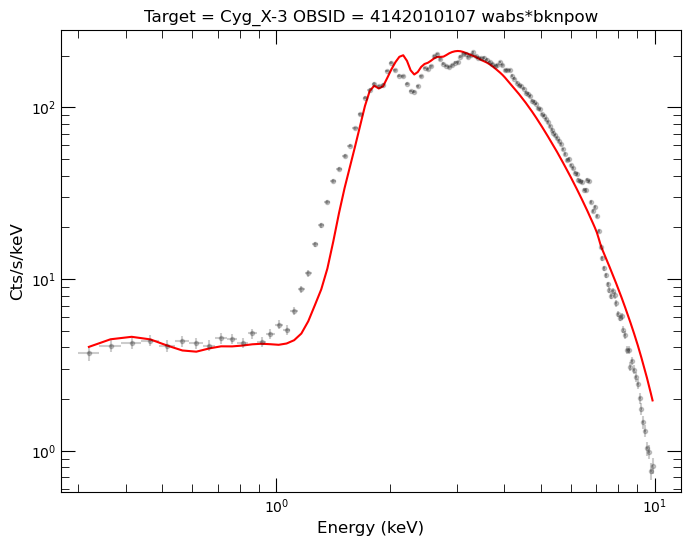

In [16]:
%matplotlib inline
xspec.Plot.device='/null'
xspec.Plot.xAxis='keV'
xspec.Plot('lda')
cr=xspec.Plot.y()
crerr = xspec.Plot.yErr()
en = xspec.Plot.x()
enwid = xspec.Plot.xErr()
mop = xspec.Plot.model()
target = fits.open(spec.fileName)[1].header['OBJECT']


fig = figure(figsize=[8,6])
ylabel('Cts/s/keV', fontsize=12)
xlabel('Energy (keV)', fontsize=12)
title('Target = '+target+' OBSID = '+nicerobsID+' wabs*bknpow', fontsize=12)
yscale('log')
xscale('log')
errorbar(en, cr, xerr=enwid, yerr=crerr, fmt='k.', alpha=0.2)
plot(en, mop,'r-')

# Plot the lightcurve

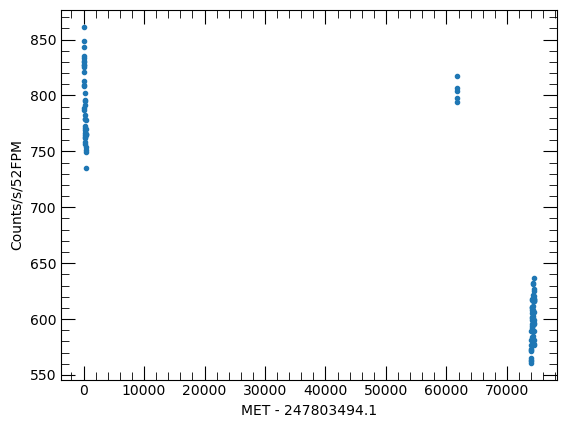

In [17]:
%matplotlib inline

lcfile = f'ni{nicerobsID}mpu7_sr.lc'
lcbkgfile = f'ni{nicerobsID}mpu7_bg.lc'
lctab = Table.read(lcfile,hdu='RATE')

#fig =subplots(1,1,figsize=[10,6])
plot(lctab['TIME'], lctab['RATE'],'.')
tmp = xlabel(f"MET - {lctab.meta['TSTART']}")
tmp = ylabel('Counts/s/52FPM')